# Import Libraries

In [91]:
import random
import os
import time
import itertools
import copy

import pandas as pd
import numpy as np

## PyTorch
import torch
from torch import nn

#import ordinal ecnoder
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder

from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.tensorboard import SummaryWriter
import torcheval.metrics as tm

## TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

## Sklearn
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

from sklearn import preprocessing, decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay

## Saving, Loading and Plotting
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# keep for TabTransformer computation (CUDA memory management)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

# Configuration

In [92]:
seed = 42
FILENAME = "train_dataset.csv"

clf = 'tb'         # 'rf', 'svm', 'knn', 'ffnn', 'tabtansf' or 'tabnet'
pre = 'pca'         # 'pca', 'lda' or 'std'
overfit = False      # True or False

ml = True           # DON'T CHANGE (True for Machine Learning, False for Deep Learning)

if clf == 'ff' or clf == 'tb' or clf == 'tf':
    overfit = True
    ml = False

print(f"Classifier: {clf}")
print(f"Preprocessing: {pre}")
print(f"Overfit: {overfit}")
print(f"Machine Learning: {ml}")


Classifier: tb
Preprocessing: pca
Overfit: True
Machine Learning: False


# Device Application

In [93]:
if not ml:
    # look for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device: {}".format(device))

Device: cuda


# Seed Fixing


In [94]:
# For reproducibility
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

seed = 42

In [95]:
if not ml:
    # Define the Data Layer        
    class MyDataset(Dataset):
        def __init__(self, X, y):
            
            self.X = torch.FloatTensor(X)
            self.y = torch.LongTensor(y)
            
            self.num_features = X.shape[1]
            self.num_classes = len(np.unique(y))
        

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return self.X[idx, :], self.y[idx]

# FFNN Architecture

In [96]:
if clf == 'ff':
    # Architecture
    class FeedForwardPlus(nn.Module):
        def __init__(self, input_size, num_classes, hidden_size, depth=1, batch_norm=False, drop=0):
            super(FeedForwardPlus, self).__init__()
            
            model = []
            model += [nn.Linear(input_size, hidden_size)]
            if batch_norm:
                model += [nn.BatchNorm1d(hidden_size)]
            model += [nn.ReLU()]

            block = [
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ]

            block_batch_norm = [
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            ]

            block_dropout = [
                nn.Dropout(drop),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ]

            for i in range(depth):
                if not batch_norm and drop == 0:
                    model += block
                elif batch_norm and drop == 0:
                    model += block_batch_norm
                elif drop > 0 and not batch_norm:
                    model += block_dropout
            
            self.model = nn.Sequential(*model)
            
            self.output = nn.Linear(hidden_size, num_classes)
            

        def forward(self, x):
            h = self.model(x)
            out = self.output(h)
            return out

        
    def test_model(model, data_loader, device):
        model.eval()
        y_pred = []
        y_test = []
        
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            y_pred += model(data)
            #print(y_pred)
            y_test += targets
            #print(targets)
        
        y_test = torch.stack(y_test).squeeze()
        y_pred = torch.stack(y_pred).squeeze()
        y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()
        
        return y_test, y_pred_c, y_pred

    def train_model(model, criterion, optimizer, epoch, scheduler, train_loader, val_loader, device, writer, log_name="model"):
        n_iter = 0
        best_valid_loss = float('inf')
        for epoch in range(epoch):
            model.train()
            
            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                y_pred = model(data)

                # Compute Loss
                loss = criterion(y_pred, targets)
            
                
                # Backward pass
                loss.backward()
                optimizer.step()

                n_iter += 1
            
            labels, _, y_pred = test_model(model, val_loader, device)
            loss_val = criterion(y_pred, labels)
            
            
            f1 = tm.MulticlassF1Score(num_classes=labels.max().item() + 1)
            f1.update(y_pred, labels)
            writer.add_scalar(log_name, f1.compute().item(), epoch)
            
        
            
            # Save best model
            if loss_val.item() < best_valid_loss:
                best_valid_loss = loss_val.item()
                if not os.path.exists('models'):
                    os.makedirs('models')
                torch.save(model.state_dict(), 'models/'+log_name)
            
            
            
            (log_name, scheduler.get_last_lr()[0], epoch)
            
            scheduler.step()
        return model, best_valid_loss

# TabNet Architecture

In [97]:
if clf == 'tb':
    class TabNet(torch.nn.Module):
        '''
        Wrapper class for TabNetClassifier
        '''
        def __init__(self, n_d,
                    n_a,
                    n_steps,
                    gamma,
                    optimizer_fn,
                    n_independent,
                    n_shared,
                    epsilon,
                    seed,
                    lambda_sparse,
                    clip_value,
                    momentum,
                    optimizer_params,
                    scheduler_params,
                    mask_type,
                    scheduler_fn,
                    device_name,
                    output_dim,
                    batch_size,
                    num_epochs,
                    unsupervised_model,
                    verbose=0):
            super(TabNet, self).__init__()

            self.batch_size = batch_size
            self.num_epochs = num_epochs
            self.unsupervised_model = unsupervised_model
            self.network = TabNetClassifier(n_d=n_d,
                                            n_a=n_a,
                                            n_steps=n_steps,
                                            gamma=gamma,
                                            optimizer_fn=optimizer_fn,
                                            n_independent=n_independent,
                                            n_shared=n_shared,
                                            epsilon=epsilon,
                                            seed=seed,
                                            lambda_sparse=lambda_sparse,
                                            clip_value=clip_value,
                                            momentum=momentum,
                                            optimizer_params=optimizer_params,
                                            scheduler_params=scheduler_params,
                                            mask_type=mask_type,
                                            scheduler_fn=scheduler_fn,
                                            device_name=device_name,
                                            output_dim=output_dim,
                                            verbose=verbose)
        
        def fit_model(self, X_train, y_train, X_val, y_val, criterion):
            self.network.fit(X_train=X_train, 
                            y_train=y_train, 
                            eval_set=[(X_train,y_train),(X_val, y_val)], 
                            eval_metric=['balanced_accuracy'], 
                            patience=10, 
                            batch_size=self.batch_size, 
                            virtual_batch_size=128, 
                            num_workers=0, 
                            drop_last=True, 
                            max_epochs=self.num_epochs, 
                            loss_fn=criterion, 
                            from_unsupervised=self.unsupervised_model)

        def predict(self, X):
            return self.network.predict(X)
        
        def explain(self, X):
            return self.network.explain(X)
        
        def feature_importances(self):
            return self.network.feature_importances_

    def get_unsupervised_model(n_d_a,n_step,n_independent,n_shared,gamma,lr):
        tabnet_params = dict(n_d=n_d_a, 
                            n_a=n_d_a,
                            n_steps=n_step,
                            gamma=gamma,
                            n_independent=n_independent,
                            n_shared=n_shared,
                            lambda_sparse=1e-3,
                            optimizer_fn=torch.optim.AdamW, 
                            optimizer_params=dict(lr=lr),
                            mask_type="sparsemax",
                            verbose=0
                            )
        unsupervised_model = TabNetPretrainer(**tabnet_params)
        return unsupervised_model




# TabTransformer Architecture

In [98]:
if clf == 'tf':
    class TabTransformer(torch.nn.Module):
        def __init__(self, num_features, num_classes, dim_embedding=8, num_heads=2, num_layers=2):
            super(TabTransformer, self).__init__()
            self.embedding = torch.nn.Linear(num_features, dim_embedding)
            encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.classifier = torch.nn.Linear(dim_embedding, num_classes)

        def forward(self, x):
            x = self.embedding(x)
            x = x.unsqueeze(1)  # Adding a sequence length dimension
            x = self.transformer(x)
            x = torch.mean(x, dim=1)  # Pooling
            x = self.classifier(x)
            return x
    
    def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
        n_iter = 0

        best_model = None
        best_val_loss = float('inf')
        epochs_since_last_improvement = 0

        start = time.time()

        loss_history = []
        val_loss_history = []

        for epoch in range(epochs):
            model.train()

            start_epoch = time.time()

            loss_train = 0
            for data, targets in data_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets.long())
                loss.backward()
                optimizer.step()
                n_iter += 1
                loss_train += loss.item()

            scheduler.step()
            loss_train /= len(data_loader)

            # Compute Val Loss
            val_loss,_,_ = test_model(model, criterion, val_loader)

            loss_history.append(loss_train)
            val_loss_history.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)
                epochs_since_last_improvement = 0
            elif epochs_since_last_improvement >= patience:
                break
            else:
                epochs_since_last_improvement += 1

            print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(epoch+1,
                epochs, time.time() - start_epoch, loss_train, val_loss, epochs_since_last_improvement), end='\r')

        print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

        return best_model, loss_history, val_loss_history


def test_model(model, criterion, loader):
    model.eval()
    y_pred = torch.tensor([],requires_grad=True).to(device)
    y_true = torch.tensor([],requires_grad=True).to(device)

    total_loss = 0.0
    
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets.long())
        total_loss += loss.item()
        y_pred = torch.cat((y_pred, preds.squeeze()))
        y_true = torch.cat((y_true, targets.detach()))

    avg_loss = total_loss / len(loader)
    return avg_loss, y_pred.squeeze(), y_true.squeeze()

# Data Cleaning

In [99]:
FILENAME = "train_dataset.csv"
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

# 7
oe = OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = LabelEncoder()
y = le.fit_transform(y)

if not ml:
    # Separate train, val, and test
    indices = np.arange(X.shape[0])
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.4, stratify=y[temp_idx], random_state=seed)

    X_train = X[train_idx, :]
    y_train = y[train_idx]
    X_val = X[val_idx, :]
    y_val = y[val_idx]
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
else:
    print("sosa")
    indices = np.arange(X.shape[0])
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=y[temp_idx], random_state=seed)

    fold = np.zeros(X.shape[0])
    fold[train_idx] = -1
    fold[val_idx] = 0

    ps = PredefinedSplit(fold)
    ps.get_n_splits()

    X_train = X[train_idx, :]
    y_train = y[train_idx]
    X_val = X[val_idx, :]
    y_val = y[val_idx]
    X_test = X[test_idx, :]
    y_test = y[test_idx]





# Preprocessing

### Scaling & Dimensionality Reduction

In [100]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

if overfit:
    X_test = scaler.transform(X_test)

if pre == 'pca' or pre == 'lda':
    if pre == 'pca':
        print("Applying PCA")
        pre = decomposition.PCA(n_components='mle', svd_solver='full')
        pre.fit(X_train)
        pre.transform(X_train)
        pre.transform(X_val)
        if overfit:
            pre.transform(X_test)
    elif pre == 'lda':
        print("Applying LDA")
        pre = LinearDiscriminantAnalysis()
        pre.fit(X_train, y_train)
        pre.transform(X_train)
        pre.transform(X_val)
        if overfit:
            X_test = pre.transform(X_test)

Applying PCA


# Dataset/Tensor Creation

In [101]:
if not ml:
    if clf == 'ff':
        train_dataset = MyDataset(X_train, y_train)
        val_dataset = MyDataset(X_val, y_val)
        test_dataset = MyDataset(X_test, y_test)
    elif clf == 'tf' or clf == 'tb':
        num_feature = X_train.shape[1]
        num_classes = len(np.unique(y_train))
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=y_val.shape[0], shuffle=False)
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    print(class_weights)

{0: np.float64(4.069593536153022), 1: np.float64(0.338110666630134), 2: np.float64(1.132579964205406), 3: np.float64(4.543873699714628), 4: np.float64(98.7202), 5: np.float64(2.983745390799734), 6: np.float64(1.196724530863599), 7: np.float64(63.855239327296246), 8: np.float64(0.2880440935324428), 9: np.float64(0.9752262219939147)}


# Train

### Model Selection with best hp configuration

# Random Forest

In [102]:
if clf == 'rf':
    param_grid = {
        'n_estimators': [50],
        'criterion': ['gini']
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
    

# SVM

In [103]:
if clf == 'svm':
    param_grid = {
        'C': [1000], 
        'kernel': ['rbf'],
        'gamma': ['auto']  
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')

# KNN

In [104]:
if clf == 'knn':
    param_grid = {
        'n_neighbors': [15],
        'p': [1]
    }

    scoring = ['balanced_accuracy', 'f1_weighted']

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
    
    grid.fit(X,y)
    
    print(grid.cv_results_['mean_test_balanced_accuracy'])
    print(grid.cv_results_['mean_test_f1_weighted'])
    
    #test it
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(balanced_accuracy_score(y_test, y_pred))
    print(f1_score(y_test, y_pred, average='weighted'))
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    

# Feed Forward Neural Network

In [105]:
if clf == 'ff':
#hyperparameters
    seed = 42
    batch_sizes = [512]
    hidden_sizes = [32] # 64
    batch_norm_list = [False]
    drop = 0
    depths = [2]
    num_epochs = 10
    learning_rate = 0.01
    gammas = [0.5]
    step_size = num_epochs / 4

    hyperparameters = itertools.product(batch_sizes, hidden_sizes, depths, gammas, batch_norm_list)



    # #grid search loop
    lowest_loss = float('inf')
    best_model_params = None
    best_model = None

    for batch_size, hidden_size, depth, gamma, batch_norm in hyperparameters:
        fix_random(seed)
        
        start = time.time()

        log_name = "B"+str(batch_size)+"-dim"+str(hidden_size)+"-dp"+str(depth)+"-ep"+str(num_epochs)+"-lr"+str(learning_rate)+"-steplr"+str(step_size)+"-gamma"+str(gamma)+"-BN"+str(batch_norm)+"-drop"+str(drop)
        print(log_name, end=", ")
        
        #start tensorboard
        writer = SummaryWriter('runs/'+log_name)

        # Create relative dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        #define architecture, loss and optimizer
        model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
        model.to(device)
        
        #train
        criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        model, best_valid_loss = train_model(model, criterion, optimizer, num_epochs, scheduler, train_loader, val_loader, device, writer, log_name)

        writer.add_hparams({'hparam/bsize': batch_size, 'hparam/hidden size': hidden_size, 'hparam/depth':depth+2, 'hparam/scheduler': gamma,'hparam/batch norm': batch_norm}, {'best loss': best_valid_loss})
        writer.flush()

        if best_valid_loss < lowest_loss:
            best_model = model
            lowest_loss = best_valid_loss
            best_model_params = (batch_size, hidden_size, depth, gamma, batch_norm, log_name)

        print("time elapsed:", time.time() - start)
    writer.close()

    #save the model with the best hyperparameters
    import pickle
    with open('best_model_params.pkl', 'wb') as f:
        pickle.dump(best_model_params, f)

    #save the best model
    torch.save(best_model.state_dict(), 'models/best_ffnn_model')


    # Load the best model
    if best_model_params:
        _, _, _, _, _, best_log_name = best_model_params
        model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)





# Tabnet


In [106]:


if clf == 'tb':
    nums_epochs = [10]
    batch_sizes = [256]
    patience = [10]
    n_d_a = [16]
    n_shared = [8]
    n_indipendents = [1] 
    n_steps = [9]
    gamma = [1.0]
    epsilon = [1e-15]
    learning_rate = [0.01]
    pretraining_ratio = [0.5]
    momentum = [0.99]
    hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, n_d_a, n_indipendents, n_shared, n_steps, gamma, epsilon, learning_rate, pretraining_ratio, momentum))

    current_iter = 0
    best_acc = 0
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
    for num_epochs, batch_size, patience_, n_d, n_i, n_s, n_steps_, gamma_, epsilon_, lr, pretraining_ratio_, moment in hyperparameters:
        #print epoch
        print(f'Hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}')

        unsupervised_model = get_unsupervised_model(n_d, n_steps_, n_i, n_s, gamma_, lr)
            
        unsupervised_model.fit(
            X_train=X_train,
            eval_set=[X_val],
            max_epochs=num_epochs,
            patience=patience_,
            batch_size=batch_size,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            pretraining_ratio=pretraining_ratio_,
        )

        model = TabNet(n_d=n_d,
                    n_a=n_d,
                    n_steps=n_steps_,
                    gamma=gamma_,
                    optimizer_fn=torch.optim.AdamW,
                    n_independent=n_i,
                    n_shared=n_s,
                    epsilon=epsilon_,
                    seed=seed,
                    lambda_sparse=1e-4,
                    clip_value=1,
                    momentum=moment,
                    optimizer_params=dict(lr=lr),
                    scheduler_params=dict(step_size=10, gamma=0.9),
                    mask_type='sparsemax',
                    scheduler_fn=torch.optim.lr_scheduler.StepLR,
                    device_name=device,
                    output_dim=len(np.unique(y_train)),
                    batch_size=batch_size,
                    num_epochs=num_epochs,
                    unsupervised_model=None,
                    verbose=0)
        model.fit_model(X_train, y_train, X_val, y_val, criterion)    
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)
            best_hyperparameters = f"num_epochs={num_epochs}, batch_size={batch_size}, patience={patience_}, n_d={n_d}, n_indipendent={n_i}, n_shared={n_s}, n_steps={n_steps_}, gamma={gamma_}, epsilon={epsilon_}, lr={lr}, pretraining_ratio={pretraining_ratio_}, momentum={moment}"
        current_iter += 1

Hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=8, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Stop training because you reached max_epochs = 10 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 388.3460388183594


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_1_balanced_accuracy = 0.96298


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# TabTransformer

In [107]:
if clf == 'tf':
    nums_epochs = [20]
    batch_sizes = [512]
    patience = [10]
    dim_embedding = [32]
    num_heads = [8]
    num_layers = [16]
    learning_rate = [0.001]
    hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate))
    
    #Initialize the model, loss, and optimizer
    best_loss = float('inf')
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
    current_iter = 0
    for epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr in hyperparameters:
        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, drop_last=True)

        model = TabTransformer(num_feature, num_classes).to(torch.device('cuda'))
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

        model, loss_history, val_loss_history = train_model(model, criterion, optimizer, epochs, train_loader, val_loader, device, scheduler, patience_)
        val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)
            best_hyperparameters = f"epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}"

        print(f'Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
        print(f'Validation Loss: {val_loss}')

        current_iter += 1

# Testing/Evaluation

### Model Saving + Best hp configuration saving

Best model hyperparameters: num_epochs=10, batch_size=256, patience=10, n_d=16, n_indipendent=1, n_shared=8, n_steps=9, gamma=1.0, epsilon=1e-15, lr=0.01, pretraining_ratio=0.5, momentum=0.99
Accuracy: 0.9795790198739895

Balanced accuracy: 0.9669673262474288

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00     14599
           2       0.97      0.98      0.97      4359
           3       0.88      1.00      0.94      1086
           4       0.72      1.00      0.84        50
           5       1.00      0.80      0.89      1654
           6       0.87      1.00      0.93      4124
           7       0.55      1.00      0.71        77
           8       1.00      1.00      1.00     17137
           9       1.00      0.91      0.95      5062

    accuracy                           0.98     49361
   macro avg       0.90      0.97      0.92     49361
weighted avg       0.98      0.98  

<Figure size 2000x2000 with 0 Axes>

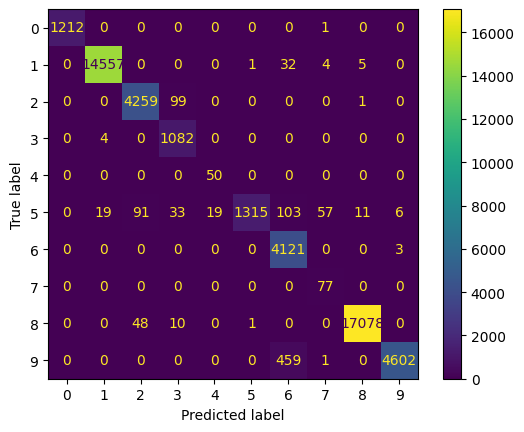

In [109]:
if clf == 'ff':
    test_loader = DataLoader(test_dataset, batch_size=batch_sizes[0])
    #print best hp
    # print(best_model_params)
    # Choose and load the best model and evaluate it on the test set
    filename = "models/best_ffnn_model"

    hidden_size = 32  # Ensure the hidden size matches the saved model
    depth = 2  # Ensure the depth matches the saved model
    batch_norm = False  # Ensure batch_norm matches the saved model
    model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
    model.load_state_dict(torch.load(filename))
    model.to(device)
    model.eval()
    y_test, y_pred_c, y_pred = test_model(model, test_loader, device)

    # print accuracy
    print(tm.MulticlassAccuracy().update(y_pred_c, y_test).compute().item())

    # print precision
    print(tm.MulticlassPrecision(num_classes=y_test.max().item() + 1).update(y_pred, y_test).compute().item())

    # Classification report with torcheval
    f1 = tm.MulticlassF1Score(num_classes=y_test.max().item() + 1, )
    f1.update(y_pred, y_test)
    print(f1.compute().item())

    #confusion matrix
    conf_matrix = tm.MulticlassConfusionMatrix(num_classes=y_test.max().item() + 1)
    conf_matrix.update(y_pred_c, y_test)

    #use sklearn confusion matrix
    ConfusionMatrixDisplay(conf_matrix.compute().cpu().numpy()).plot()

    #compute classification report
    print(classification_report(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))

    #save classification report as txt
    with open('ffnn_classification_report.txt', 'w') as f:
        f.write(classification_report(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))

    #compute balanced accuracy
    print("balanced accuracy: ",balanced_accuracy_score(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))
    
if clf=='tb':
    #save best model as best_tabnet
    torch.save(best_model, 'models/tabnet/tb')

    #save best hp
    with open('models/best_tb_hp.txt', 'w') as f:
        f.write(best_hyperparameters)
        
    print(f'Best model hyperparameters: {best_hyperparameters}')
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc}\n')

    #compute the classficication report
    from sklearn.metrics import classification_report,balanced_accuracy_score

    #print balanced accuracy
    print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n')

    
    print(classification_report(y_test, y_pred))
    #save it
    with open('models/tb_report.txt', 'w') as f:
        f.write(classification_report(y_test, y_pred))
    #compute the confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(20,20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot()
    plt.show()
    
if clf=='tf':
    #save model with pickle
    with open('models/tabtransf/best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    #save best hyperparameters
    with open('models/tabtransf/best_hyperparameters.pkl', 'wb') as f:
        pickle.dump(best_hyperparameters, f)
    test_loss, y_pred, y_true = test_model(best_model, criterion, test_loader)
    y_pred = torch.argmax(y_pred, dim=1)
    print(f'Best hyperparameters: {best_hyperparameters}')
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {accuracy_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')
    #print balanced accuracy
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')
    #print f1 score
    print(f'F1 Score: {f1_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average="weighted")}')
    #compute confusion matrix
    cm = confusion_matrix(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot()
    plt.show()
    #print classification report
    print(f'Classification Report:\n {classification_report(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())}')